## Define the Data Generating Distribution

To examine different approximations to the true loss surface of a particular data generating distribution $P(X,Y)$ we must first define it. We will work backwards by first defining a relationship between random variables and then construct the resulting distribution. Let 

$$y=mx+\epsilon$$

where $X \sim U[0,1]$ ($p(x)=1$) and $\epsilon \sim \mathcal{N}(0,s^2)$ is the noise term. We immediately see that $y$ can be interpreted as the result of a reparameterization, thus given a particular observation $X=x$ the random variable $Y$ is also distributed normally $\mathcal{N}(mx,s^2)$ with the resulting pdf.

$$p(y|x) = \frac{1}{\sqrt{2\pi s^2}}\exp\bigg(-\frac{(y-mx)^2}{2 s^2}\bigg)$$

In this way, we can trivially define the joint pdf

$$p(x,y) = p(y|x)p(x) = p(y|x) = \frac{1}{\sqrt{2\pi s^2}}\exp\bigg(-\frac{(y-mx)^2}{2 s^2}\bigg)$$

## Visualizing the Joint Distribution

We can create observations from $P(X,Y)$ via ancestral sampling, i.e. we first draw a sample  $x\sim p(x)$ and then use it to draw a sample $y \sim p(y|x)$ resulting in $(x,y) \sim P(X,Y)$.

In [1]:
import numpy as np

class P():
    
    def __init__(self, m, s):
        
        self.m = m # Slope of line
        self.s = s # Standard deviation of injected noise
        
    def sample(self, size):
        
        x = np.random.uniform(size=size)
        y = []
        for xi in x:
            y.append(np.random.normal(self.m*xi,self.s))
        return (x,y)

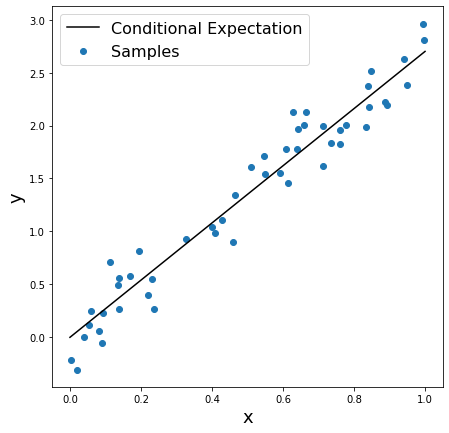

In [50]:
import matplotlib.pyplot as plt

m = 2.7
s = 0.2
p = P(m,s)
x,y = p.sample(50)
plt.figure(figsize=(7,7))
plt.plot([0,1],[0,m],label="Conditional Expectation", c='k')
plt.scatter(x,y, label="Samples")

plt.xlabel("x",fontsize=18)
plt.ylabel('y', fontsize=18)
plt.legend(fontsize=16)
plt.show()

## Fitting a Line

We now wish to fit a line to the points drawn from $P(X,Y)$. To do this we must introduce a model and a loss function. Our model is a line with a y-intercept of $0$, $y=\theta x$, and we use the standard sum of squared errors (SSE) loss function

$$ L(\theta) = \frac{1}{N}\sum\limits_{i=1}^N (\theta x_i-y_i)^2$$

## Examining Loss Surfaces

The above SSE is where most introductions to machine learning start. However, we can look a little bit closer. Not all loss surfaces are created equally because in practice the loss functions are calculated from only a sample of the true distribution. To see this, let us first take a look at what the **true** loss surface is

\begin{align}
L_{\text{True}}(\theta) &= \mathop{\mathbb{E}}_{(x,y)\sim P}[(\theta x-y)^2] \\
&= \theta^2 \mathbb{E}[x^2]-2\theta\mathbb{E}[xy] +\mathbb{E}[y^2] \\
\end{align}

Let us begin with the first expectation.

\begin{align}
\mathbb{E}[x^2] &= \int_0^1 \int_{-\infty}^{\infty} x^2 p(x,y) dy dx \\
&= \int_0^1 x^2 \bigg(\int_{-\infty}^{\infty} p(y|x) dy \bigg) dx \\
&= \int_0^1 x^2 dx \\
&= \frac{1}{3}
\end{align}

The expectation of $xy$ follows a similar pattern

\begin{align}
\mathbb{E}[xy] &= \int_0^1 \int_{-\infty}^{\infty} xy p(x,y) dy dx \\
&= \int_0^1 x \bigg(\int_{-\infty}^{\infty} yp(y|x) dy \bigg) dx \\
&= \int_0^1 x(mx) dx \\
&= m\int_0^1 x^2 dx \\
&= \frac{m}{3}
\end{align}

As well as the final expectation...

\begin{align}
\mathbb{E}_{P(X,Y)}[y^2] &= \int_0^1 \int_{-\infty}^{\infty} y^2 p(x,y) dy dx \\
&= \int_0^1 \mathbb{E}_{P(Y|X)}[y^2] dx
\end{align}

Here we use the fact that

$$\mathbb{E}_{P(Y|X)}[y^2] = Var[y]+(\mathbb{E}_{P(Y|X)}[y])^2$$

to arrive at 

\begin{align}
\mathbb{E}_{P(X,Y)}[y^2] &= \int_0^1 s^2+(mx)^2 dx \\
&= s^2 + \frac{m^2}{3}
\end{align}

We now substitute all three results into the definition of $L_{\text{True}}$

\begin{align}
L_{\text{True}}(\theta) &= \frac{1}{3}\theta^2 -\frac{2m}{3}\theta + \frac{m^2}{3} + s^2 \\
&= \frac{1}{3}(\theta - m)^2 + s^2
\end{align}

where we see the classic results that
$$\text{argmin}_{\theta} [L_{\text{True}}(\theta)] = m$$
and
$$L_{\text{True}}(m) = s^2$$
showing us that the best we can do in minimizing the loss is governed by the gaussian noise injected into the data

## Visualize True Loss Surface

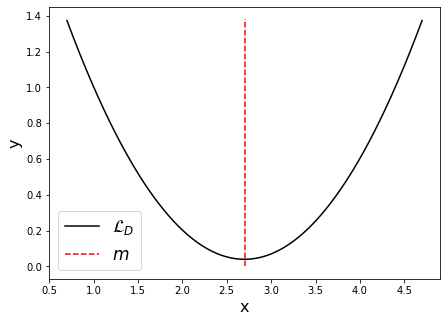

In [48]:
def true_loss(theta):
    return 1/3*(theta-m)**2 + s**2

thetas = np.linspace(m-2,m+2,1000)
plt.figure(figsize=(7,5))
plt.plot(thetas, true_loss(thetas),c='k',label="$\mathcal{L}_D$")
plt.plot([2.7,2.7],[0,1.38],c='r',ls='dashed',label="$m$")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.legend(fontsize=17)
plt.show()

## Approximate Loss Surfaces

The question now becomes, what does the loss surface look like when we only include a finite number of observations from the data generating distribution $P(X,Y)$? We can find an expression for it by expanding the previous defintion of the SSE above

\begin{align}
L(\theta) &= \frac{1}{N}\sum\limits_{i=1}^N (\theta x_i-y_i)^2 \\
&= \theta^2 \frac{1}{N}\sum\limits_{i=1}^N x_i^2 -2\theta \frac{1}{N}\sum\limits_{i=1}^N x_i y_i + \frac{1}{N}\sum\limits_{i=1}^N y_i^2 \\
\end{align}

In [4]:
def approx_loss(theta, x_vals, y_vals):
    x_sq = np.power(x,2).mean()
    xy = (x*y).mean()
    y_sq = np.power(y,2).mean()
    return theta**2*x_sq - 2*theta*xy + y_sq

Now we can examine what different approximations to the loss surface look like relative to the true loss surface

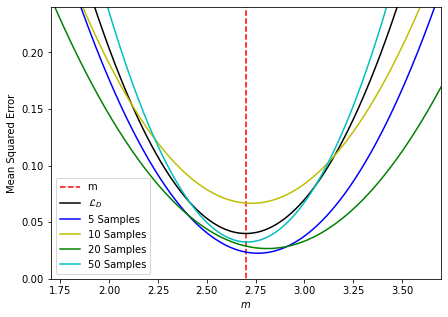

In [47]:
plt.figure(figsize=(7,5))
plt.plot([m,m],[-0.1,1.0],ls='dashed',c='r',label='m')
plt.plot(thetas, true_loss(thetas),c='k',label='$\mathcal{L}_D$')
sample_sizes = [5,10,20,50]
colors = ['b','y','g','c','m']
for ss,color in zip(sample_sizes,colors):
    x,y = p.sample(ss)
    plt.plot(thetas, approx_loss(thetas,x,y), color, label="{} Samples".format(ss))
plt.legend()
plt.ylim(0.0,s**2 + s)
plt.ylabel("Mean Squared Error")
plt.xlim(m-1.0,m+1.0)
plt.xlabel("$m$")
plt.show()

Now let us approximate the derivative of the true loss surface. We begin with calculating the true derivative

\begin{align}
L_{\text{True}}(\theta) &= \frac{1}{3}(\theta - m)^2 + s^2 \\
\frac{\partial L_{\text{True}}}{\partial \theta}(\theta) &= \frac{2}{3}(\theta-m)
\end{align}

Meanwhile the derivative of the approximate loss function is

\begin{align}
L(\theta) &= \theta^2 \frac{1}{N}\sum\limits_{i=1}^N x_i^2 -2\theta \frac{1}{N}\sum\limits_{i=1}^N x_i y_i + \frac{1}{N}\sum\limits_{i=1}^N y_i^2 \\
\frac{\partial L}{\partial \theta}(\theta) &= \theta \frac{2}{N}\sum\limits_{i=1}^N x_i^2 -\frac{2}{N}\sum\limits_{i=1}^N x_i y_i
\end{align}

and we immediately see that our approximation to the minimum of this loss function is

$$\theta^* = \frac{\sum\limits_{i=1}^N x_i y_i}{\sum\limits_{i=1}^N x_i^2}$$

We will draw samples in the range from $[0,N]$. For each sample size, we will use 70% of it to approximate the minimum of that surface using $\theta^*$ above. Then we will approximate the gradient of the loss surface at $\theta^*$ using the remaining 30% of the data, as well as with all N of the data. For each case we will calculate the error between it and the **true** gradient of the loss surface. We will then plot both of the error rates as a function of sample size.

In [22]:
def partial_L(theta,x,y):
    x_sq = np.power(x,2).mean()
    xy = (x*y).mean()
    return 2*(theta*x_sq-xy)

def partial_L_True(theta):
    return 2/3*(theta-m)

def approx_argmin(x,y):
    x_sq = np.power(x,2).sum()
    xy = (x*y).sum()
    return xy/x_sq

In [29]:
err_tot = []
err_test = []
grad = False
for samp_size in range(10,1000):
    x,y = p.sample(samp_size)
    index = int(samp_size*0.7)
    theta_min = approx_argmin(x[:index], y[:index])
    pL_test = partial_L(theta_min, x[index:], y[index:])
    pL_tot = partial_L(theta_min, x, y)
    pL_T = partial_L_True(theta_min)
    err_tot.append(np.abs(pL_T-pL_tot))
    err_test.append(np.abs(pL_T-pL_test))
    

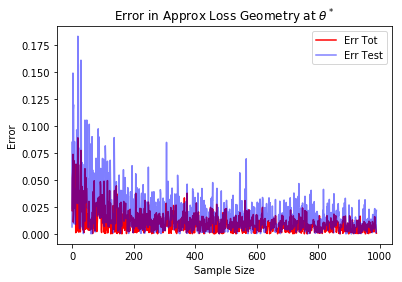

In [29]:
plt.plot(err_tot, c='r', label='Err Tot')
plt.plot(err_test, c='b', label='Err Test', alpha=0.5)
plt.ylabel('Error')
plt.xlabel('Sample Size')
plt.title('Error in Approx Loss Geometry at $\\theta^*$')
plt.legend()
plt.show()

In [35]:
err_tot = []
err_test = []
err_train = []
grad = False
for samp_size in range(10,1000):
    x,y = p.sample(samp_size)
    index = int(samp_size*0.7)
    theta_min = approx_argmin(x[:index], y[:index])
    loss_test = approx_loss(theta_min, x[index:], y[index:])
    loss_tot = approx_loss(theta_min, x, y)
    loss_train = approx_loss(theta_min, x[:index], y[:index])
    loss_true = true_loss(theta_min)
    err_test.append(np.abs(loss_true-loss_test))
    err_tot.append(np.abs(loss_true-loss_tot))
    err_train.append(np.abs(loss_true-loss_train))

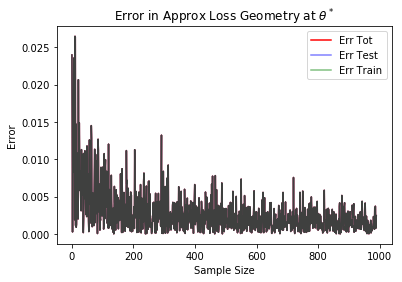

In [38]:
plt.plot(err_tot, c='r', label='Err Tot')
plt.plot(err_test, c='b', label='Err Test', alpha=0.5)
plt.plot(err_test, c='g', label='Err Train', alpha=0.5)
plt.ylabel('Error')
plt.xlabel('Sample Size')
plt.title('Error in Approx Loss Geometry at $\\theta^*$')
plt.legend()
plt.show()

$\sum_i^N$

### Why is the generalization biased if calcuated with the training data?

First, we define bias $b(\hat{\theta}, \theta)$. The bias of an estimator, $\hat{\theta}$, that is estimating a true population value $\theta$ from a distribution $P$, is given by,

$$\text{bias}(\hat{\theta}, \theta) = \mathbb{E}_P[\hat{\theta}] - \theta.$$

When assessing a model's generalizability, we are interested in approximating the value of the true loss function. In other words, if we have an estimator, $\hat{\mathcal{L}}$, for the true loss $\mathcal{L}_{\text{true}}$ we measure the bias of the our estimator with,

$$\text{bias}(\hat{\mathcal{L}}, \mathcal{L}_{\text{true}}) = \mathbb{E}_P[\hat{\mathcal{L}}] - \mathcal{L}_{\text{true}}.$$